## Proteins expression predictions (using Node2Vec approach)

#### Plan:
<ul>
    <li>Use graph structure to train Node2Vec model and get node embeddings for each protein</li>
    <li>Use any regressor model to train on node embeddings and predict protein expression</li>
    <li>Get embeddings for test data and validate regressor</li>
</ul>

In [140]:
#initial imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import stellargraph as sg
from stellargraph import StellarGraph
from tensorflow import keras
from tqdm import tqdm

In [18]:
#stellar graph imports for Node2Vec
from stellargraph.data import BiasedRandomWalk, EdgeSplitter, UniformRandomWalk, UnsupervisedSampler
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification

### Load graph data

In [4]:
edges = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/edges.csv", sep=",") 
edges.head()

,node_1,node_2
0,344,50
1,344,153
2,344,532
3,344,679
4,344,986


In [6]:
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(edges, source='node_1', target='node_2', create_using=Graphtype)

In [7]:
print(nx.info(G))

Graph with 10000 nodes and 594174 edges


/tmp/ipykernel_370193/2606185536.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


#### Train Node2Vec model

In [120]:
batch_size = 64
epochs = 10
emb_size = 128
walk_number = 100
walk_length = 5

In [121]:
SG = StellarGraph.from_networkx(G)

In [122]:
rw = BiasedRandomWalk(SG, n=walk_number, length=walk_length, p=0.5, q=2.0)

In [123]:
unsupervised_sampler = UnsupervisedSampler(SG, nodes=list(SG.nodes()), walker=rw)

In [124]:
generator = Node2VecLinkGenerator(SG, batch_size)

In [125]:
node2vec = Node2Vec(emb_size, generator=generator)

In [126]:
x_inp, x_out = node2vec.in_out_tensors()

In [127]:
prediction = link_classification(output_dim=1, output_act="sigmoid", edge_embedding_method="dot")(x_out)

link_classification: using 'dot' method to combine node embeddings into edge embeddings


In [128]:
model = keras.Model(inputs=x_inp, outputs=prediction)

In [129]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.binary_crossentropy)

In [130]:
history = model.fit(
    generator.flow(unsupervised_sampler), epochs=epochs, verbose=1, shuffle=True
)

Epoch 1/10
125000/125000 [==============================] - 1197s 10ms/step - loss: 0.7552
Epoch 2/10
125000/125000 [==============================] - 1192s 10ms/step - loss: 0.7355
Epoch 3/10
125000/125000 [==============================] - 1186s 9ms/step - loss: 0.7233
Epoch 4/10
125000/125000 [==============================] - 1188s 10ms/step - loss: 0.7166
Epoch 5/10
125000/125000 [==============================] - 1191s 10ms/step - loss: 0.7128
Epoch 6/10
125000/125000 [==============================] - 1191s 10ms/step - loss: 0.7111
Epoch 7/10
125000/125000 [==============================] - 1193s 10ms/step - loss: 0.7099
Epoch 8/10
125000/125000 [==============================] - 1197s 10ms/step - loss: 0.7099
Epoch 9/10
125000/125000 [==============================] - 1197s 10ms/step - loss: 0.7098
Epoch 10/10
125000/125000 [==============================] - 1200s 10ms/step - loss: 0.7092


### Get node embeddings for  train data

In [219]:
train = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/train.csv", sep=",") 
train.head()

,target,node
0,0.251968,11142
1,0.689541,2243
2,0.678245,15514
3,0.272500,20944
4,0.248888,8721


In [43]:
train.shape

(8000, 2)

In [105]:
train_node_names = train["node"].values

In [106]:
train_node_names

array([11142,  2243, 15514, ..., 20535,  9769, 15711])

In [107]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [108]:
node_gen = Node2VecNodeGenerator(SG, batch_size).flow(train_node_names)

In [109]:
node_embeddings = embedding_model.predict(node_gen, verbose=1)

125/125 [==============================] - 0s 347us/step


In [35]:
node_embeddings.shape

(8000, 128)

### Build regressor model to predict proteins level

In [44]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [135]:
regressor = XGBRegressor(n_estimators=150, max_depth=15,  learning_rate=0.01)

In [136]:
targets = train["target"].values

In [138]:
scores = cross_val_score(estimator=regressor, X=node_embeddings, y=targets, cv=4, scoring="neg_mean_squared_error", n_jobs=-1)

In [151]:
print(f"Validation results: {scores}")

Validation results: [-0.43744031 -0.45344047 -0.43669918 -0.56970117]


In [141]:
regressor.fit(node_embeddings, targets)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Validate on test data

In [57]:
test = pd.read_csv("https://raw.githubusercontent.com/a-milenkin/Otus_HW_protein_expression/main/test.csv", sep=",")
test.head()

,target,node
0,0.279231,817
1,0.380795,9574
2,0.686527,1607
3,0.303594,4782
4,0.367374,24125


In [142]:
test_node_names = test["node"].values

In [143]:
node_gen_test = Node2VecNodeGenerator(SG, 1).flow(test_node_names)

In [144]:
test_node_embeddings = embedding_model.predict(node_gen_test, verbose=1)

2000/2000 [==============================] - 1s 335us/step


In [212]:
test_node_embeddings

array([[-0.82835424,  0.0213073 , -0.5862759 , ..., -0.30974373,
        -0.11778651,  0.12209934],
       [ 0.49578193, -0.10690324, -0.23781024, ..., -0.1380919 ,
        -0.59519374, -0.20721357],
       [ 0.00399223, -0.32891715,  0.101818  , ...,  0.04653355,
        -0.0060368 , -0.17976752],
       ...,
       [ 0.2631046 , -1.0927707 ,  0.6886001 , ...,  0.06539971,
         0.09963416, -0.08995409],
       [-0.36441943,  0.2607973 , -0.3212736 , ...,  0.33909318,
        -0.02235705,  0.11336233],
       [ 0.48098058, -0.22165926, -0.33762574, ...,  0.13691878,
        -0.20696998,  0.20531532]], dtype=float32)

In [145]:
predicts = regressor.predict(test_node_embeddings)

In [154]:
mse_test = mean_squared_error(test["target"].values, predicts)
print(f"MeanSquaredError for test data: {mse_test}")

MeanSquaredError for test data: 0.764815189247934


### Check RandomForestRegressor

In [112]:
from sklearn.ensemble import RandomForestRegressor

In [161]:
regressor_forest = RandomForestRegressor(max_depth=15, n_jobs=-1, n_estimators=150)

In [162]:
regressor_forest.fit(node_embeddings, targets)

RandomForestRegressor(max_depth=15, n_estimators=150, n_jobs=-1)

In [164]:
predicts_forest = regressor_forest.predict(test_node_embeddings)
mse_test = mean_squared_error(test["target"].values, predicts_forest)
print(f"MeanSquaredError for test data (for RandomForest): {mse_test}")

MeanSquaredError for test data (for RandomForest): 0.762426649964919


### Gensim + W2VEC approach

In [272]:
from gensim.models import Word2Vec

In [273]:
GraphtypeW2V = nx.Graph()
G_W2V = nx.from_pandas_edgelist(edges, source='node_1', target='node_2', create_using=GraphtypeW2V)

In [274]:
#important! adding absent nodes from train data and test data
G_W2V.add_nodes_from([n for n in train_node_names])
G_W2V.add_nodes_from([n for n in test_node_names])

In [275]:
SG_W2V = StellarGraph.from_networkx(G_W2V)

In [276]:
rw = BiasedRandomWalk(SG_W2V)

walks = rw.run(
    nodes=list(SG_W2V.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)


In [278]:
#build Word2Vec model
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, vector_size=128, window=5, min_count=0, sg=1, workers=2, epochs=1, negative=15)

In [279]:
w2v_train_embeddings = [list(model.wv[str(n)]) for n in train_node_names]

In [281]:
regressor_w2v = XGBRegressor(n_estimators=500, max_depth=25,  learning_rate=0.01, random_state=143)
targets = train["target"].values
X = pd.DataFrame(w2v_train_embeddings)
#split validation set
X_train, X_val, y_train, y_val = train_test_split(X, targets, test_size=0.2)
regressor_w2v.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=25,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=16, num_parallel_tree=1, random_state=143,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [282]:
r2score = regressor_w2v.score(X, targets)
print(f"R2 for W2V regressor {r2score}")

R2 for W2V regressor 0.8623162588276287


In [283]:
w2v_test_embeddings = [list(model.wv[str(n)]) for n in test_node_names]
predicts_w2v = regressor_w2v.predict(pd.DataFrame(w2v_test_embeddings))

In [284]:
mse_test = mean_squared_error(test["target"].values, predicts_w2v)
print(f"MeanSquaredError for test data (for W2V+XGB): {mse_test}")

MeanSquaredError for test data (for W2V+XGB): 0.5265440236325964


In [285]:
from sklearn.metrics import r2_score

In [287]:
r2_test = r2_score(test["target"].values, predicts_w2v)
print(f"R2 for test data (for W2V+XGB): {r2_test}")

R2 for test data (for W2V+XGB): 0.2998874562207178


<AxesSubplot:xlabel='real_data', ylabel='predicts'>

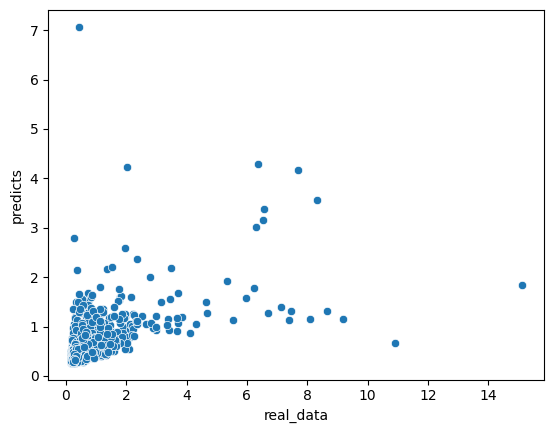

In [296]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=pd.DataFrame({'real_data':test["target"].values, 'predicts':predicts_w2v}), x='real_data', y='predicts')

### Compare with mean

In [298]:
mean_values = [targets.mean()] * test.shape[0]
mse_test_mean = mean_squared_error(test["target"].values, mean_values)
print(f"MeanSquaredError for test data (for Mean): {mse_test_mean}")

MeanSquaredError for test data (for Mean): 0.7535519418707666


### Выводы. Лучшая метрика по MSE получилась 0.5265 (R2=0.299). Модель W2Vect+Xgboost(with validation).Это гораздо лучше чем модели Node2Vec. Для сравнения с бейзлайном была выбрана модель среднего по тренировачной выборке. Бейзлайн показал метркику 0.7535 по MSE. Т.о. наша модель опередила бейзлайн на 0.23 по MSE, что говорит об успехе. Визуализация на scatter тоже стала гораздо лучше.
